# **D**eep **C**onvolutional **G**enterative **A**dversarial **N**etwork

with the LEGO Bricks Dataset

### Hardware Check

In [1]:
def get_hardware_info(use_in_notebook=True, install_packages=True):
    import platform
    system_name = platform.system()

    if install_packages:
        if system_name.lower() == "windows":
            %pip install psutil    # or: conda install psutil
            %pip install gputil
            %pip install py-cpuinfo
        elif system_name.lower() == "linux":
            !pip install psutil    # or: conda install psutil
            !pip install gputil
            !pip install py-cpuinfo

    # import needed packages
    import psutil
    import GPUtil
    from cpuinfo import get_cpu_info

    if use_in_notebook:
        if install_packages:
            if system_name.lower() == "windows":
                %pip install ipython
            elif system_name.lower() == "linux":
                !pip install ipython

        from IPython.display import clear_output
        clear_output()

    print("-"*32, "\nYour Hardware:\n")

    # General
    print("    ---> General <---")
    print("Operatingsystem:", platform.system())
    print("Version:", platform.version())
    print("Architecture:", platform.architecture())
    print("Processor:", platform.processor())

    # GPU-Information
    print("\n    ---> GPU <---")
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print("GPU Name:", gpu.name)
        print("VRAM Total:", gpu.memoryTotal, "MB")
        print("VRAM Used:", gpu.memoryUsed, "MB")
        print("Utilization:", gpu.load * 100, "%")

    # CPU-Information
    print("\n    ---> CPU <---")
    cpu_info = get_cpu_info()
    print("CPU-Name:", cpu_info["brand_raw"])
    print("CPU Kernels:", psutil.cpu_count(logical=False))
    print("Logical CPU-Kernels:", psutil.cpu_count(logical=True))
    print("CPU-Frequence:", psutil.cpu_freq().max, "MHz")
    print("CPU-Utilization:", psutil.cpu_percent(interval=1), "%")

    # RAM-Information
    print("\n    ---> RAM <---")
    ram = psutil.virtual_memory()
    print("RAM Total:", ram.total // (1024**3), "GB")
    print("RAM Available:", ram.available // (1024**3), "GB")
    print("RAM-Utilization:", ram.percent, "%")

    print(f"\n{'-'*32}")


get_hardware_info(use_in_notebook=True, install_packages=True)

-------------------------------- 
Your Hardware:

    ---> General <---
Operatingsystem: Linux
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Architecture: ('64bit', 'ELF')
Processor: x86_64

    ---> GPU <---
GPU Name: Tesla T4
VRAM Total: 15360.0 MB
VRAM Used: 0.0 MB
Utilization: 0.0 %

    ---> CPU <---
CPU-Name: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU Kernels: 1
Logical CPU-Kernels: 2
CPU-Frequence: 0.0 MHz
CPU-Utilization: 57.0 %

    ---> RAM <---
RAM Total: 12 GB
RAM Available: 11 GB
RAM-Utilization: 12.9 %

--------------------------------


### Imports

In [2]:
import os
import shutil
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}''")
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models

Using 'seaborn-v0_8''


In [3]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    title can be None, str or a list of strings.
    """
    import cv2

    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
            img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[3]))
        else:
            # there could be cases where this is wrong
            img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[3], 1))
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}'' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    ax = ax.ravel()
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            cur_img = cur_img
            cmap = "gray"

        cur_ax.imshow(cur_img, cmap=cmap)

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)


In [4]:
def get_cur_date_time_as_str():
    now = datetime.now()
    return f"{now.year:04}-{now.month:02}-{now.day:02}_{now.hour:02}-{now.minute:02}-{now.second:02}"

get_cur_date_time_as_str()

'2025-02-13_05-37-27'

In [5]:
def get_used_depth(img:np.ndarray):
    """
    Find the number of possible/used pixel values in an image.

    Only works if the pixel space is really used!
    """
    max_value = img.max()
    if max_value - 1 <= 0:
        return 1
    elif max_value - 2**8-1 <= 0:
        return 8
    elif max_value - 2**16-1 <= 0:
        return 16
    elif max_value - 2**32-1 <= 0:
        return 32
    else:
        raise ValueError("The depth of the given image is not sure:", max_value)

def get_depth(img:np.ndarray):
    """
    Returns the depth of an image in bit.
    """
    return img.dtype.itemsize * 8

def change_bit_depth_with_scaling(image, new_bit_depth=None):
    old_dtype = image.dtype
    int_types = {8: np.uint8, 16: np.uint16, 32: np.uint32, 64: np.uint64}
    float_types = {16: np.float16, 32: np.float32, 64: np.float64}

    # old depth pixel space
    old_bit_depth = old_dtype.itemsize * 8
    old_min, old_max = (0, 2**old_bit_depth - 1) if np.issubdtype(old_dtype, np.integer) else (0.0, 1.0)
    print(f"Old bit depth: {old_bit_depth} bit")

    # new datatype
    if new_bit_depth is None:
        new_bit_depth = get_used_depth(image)
        print(f"Found a used depth space of {new_bit_depth} bit")

    if np.issubdtype(old_dtype, np.integer):
        new_dtype = int_types.get(new_bit_depth, None)
        new_min, new_max = 0, 2**new_bit_depth - 1
    elif np.issubdtype(old_dtype, np.floating):
        new_dtype = float_types.get(new_bit_depth, None)
        new_min, new_max = 0.0, 1.0
    else:
        raise ValueError("Unsupported dtype")

    if new_dtype is None:
        raise ValueError(f"Unsupported bit depth: {new_bit_depth}")

    # scaling and applying
    if new_dtype == old_dtype:
        print("No datatyp change done! But dat got scaled")
    else:
        print(f"Change and scaled from {old_dtype} ({old_bit_depth} bit) -> {new_dtype} ({new_bit_depth} bit)")

    norm_array = (image.astype(np.float32) - old_min) / (old_max - old_min)
    scaled_array = norm_array * (new_max - new_min) + new_min

    return scaled_array.astype(new_dtype)

In [27]:
EXPERIMENT_NAME = get_cur_date_time_as_str() + "_DCGAN"
LOG_DIR = "./logs/fit/" + get_cur_date_time_as_str()

LATENT_SPACE_DIMS = 100
CHANNELS = 1
EPOCHS = 300
BATCH_SIZE = 128*2
LEARNING_RATE_DIS = 5e-5
LEARNING_RATE_GEN = 2e-4


os.makedirs(f"./logs", exist_ok=True)
os.makedirs(f"./checkpoints", exist_ok=True)
os.makedirs(f"./models/{EXPERIMENT_NAME}", exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs("./output/", exist_ok=True)

### Data Loading & Preprocessing

LEGO Bricks Dataset from Kaggle
- 40.000 Images of LEGO Bricks
- 50 different types of Bricks

<br>


**Kaggle API token loading**
1. Go to https://www.kaggle.com/ and create or sign in your account
2. Click on your profile picture > Settings and go to API
3. Click on 'Create New Token' and the 'kaggle.json' fie should download automatically
4. Now continue here:

In [7]:
import platform
import os
import shutil
import zipfile

def load_kaggle_dataset(author_name, dataset_name, on_google_colab,
                        download_path, goal_path,
                        kaggle_local_path="./", kaggle_file_name="kaggle.json"):

    # variables
    print("Set some variables...")
    dataset_download_name = f"{author_name}/{dataset_name}"

    zip_file_name = f"{dataset_name}.zip"
    zip_file_download_path = os.path.join(download_path, zip_file_name)

    kaggle_file_cur_path = os.path.join(kaggle_local_path, kaggle_file_name)
    kaggle_goal_path = os.path.expanduser("~/.kaggle") if platform.system().lower() == "windows" else "/root/.config/kaggle"
    kaggle_goal_file_path = os.path.join(kaggle_goal_path, kaggle_file_name)

    # make sure that the goal path exist
    os.makedirs(goal_path, exist_ok=True)
    os.makedirs(kaggle_goal_path, exist_ok=True)

    print("Finding and placing the API file...")
    # upload in google colab
    if on_google_colab:
        kaggle_local_path = "./"
        kaggle_file_cur_path = os.path.join(kaggle_local_path, kaggle_file_name)
        if os.path.exists(kaggle_file_cur_path):
            os.remove(kaggle_file_cur_path)

        from google.colab import files
        files.upload()  # choose your local 'kaggle.json' file

    # get the kaggle API file to the right spot
    if os.path.exists(kaggle_goal_file_path):
        os.remove(kaggle_goal_file_path)
    shutil.copy2(kaggle_file_cur_path, kaggle_goal_path)
    os.chmod(kaggle_goal_file_path, 600)    # set right rights
    print(f"Cpopied to: {kaggle_goal_path}")

    # init Kaggle API
    from kaggle.api.kaggle_api_extended import KaggleApi
    print("Autheticating at Kaggle API...")
    api = KaggleApi()
    api.authenticate()

    # make sure the file not exist already
    if os.path.exists(zip_file_download_path):
        os.remove(zip_file_download_path)

    # download kaggle dataset
    print("Downloading dataset...")
    #    -> dataset name just in the https link the last 2 items
    # !kaggle datasets download -d joosthazelzet/lego-brick-images
    api.dataset_download_files(dataset_download_name, path=download_path, unzip=False)

    # Unzip the downloaded dataset
    print("Unzipping dataset...")
    if os.path.exists(goal_path):
        shutil.rmtree(goal_path)
    # !unzip -q "lego-brick-images.zip" -d dataset
    with zipfile.ZipFile(zip_file_download_path, "r") as zip_ref:
        zip_ref.extractall(goal_path)

    # delete zip file
    os.remove(zip_file_download_path)

    print(f"Congratulations! Downloaded successfull '{dataset_name}' from '{author_name}' 🥳😎")



load_kaggle_dataset(
    author_name="joosthazelzet",
    dataset_name="lego-brick-images",
    on_google_colab=True,
    download_path="/content/",
    goal_path=f"/content/dataset",
    kaggle_local_path="./",
    kaggle_file_name="kaggle.json")

Set some variables...
Finding and placing the API file...


Saving kaggle.json to kaggle.json
Cpopied to: /root/.config/kaggle
Autheticating at Kaggle API...
Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
Unzipping dataset...
Congratulations! Downloaded successfull 'lego-brick-images' from 'joosthazelzet' 🥳😎


In [15]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "./dataset/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle=True,
    interpolation="bilinear"
)

example_image = next(iter(train_data.take(1))).numpy()
print("Batches:", train_data.cardinality().numpy())
print("Batch-Size:", example_image.nbytes / (1024 ** 3), "GB")
print("Files:", len(train_data.file_paths))
print("Shape:", example_image.shape)    # creating iter object and get the first output
print("Min:", round(example_image.min(), 0), "Max:", round(example_image.max(), 0))
print(f"Pixel depth: {get_depth(example_image)} bit, Used pixel depth: {get_used_depth(example_image)}bit")
print(train_data.element_spec)

Found 40000 files.
Batches: 157
Batch-Size: 0.00390625 GB
Files: 40000
Shape: (256, 64, 64, 1)
Min: 0.0 Max: 164.0
Pixel depth: 32 bit, Used pixel depth: 8bit
TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)


In [16]:
def preprocessing(image):
    # scaling around -1, 1
    max_value = 255
    shifting_scaling_factor = max_value/2
    image = (tf.cast(image, "float32") -shifting_scaling_factor) / shifting_scaling_factor
    return image

#train_data = train_data.map(lambda x: preprocessing(x))

# get shape from last batch
data_gen = iter(train_data.take(len(train_data)))
for _ in range(len(train_data)):
    cur_img = next(data_gen)

last_batch_size = cur_img.numpy().shape[0]

example_image = next(iter(train_data.take(1))).numpy()
print("Batches:", train_data.cardinality().numpy())
print("Batch-Size:", example_image.nbytes / (1024 ** 3), "GB")
print("Files:", (len(train_data)-1)*example_image.shape[0]+last_batch_size)
print("Shape:", example_image.shape)    # creating iter object and get the first output
print("Min:", round(example_image.min(), 2), "Max:", round(example_image.max(), 2))
print(f"Pixel depth: {get_depth(example_image)} bit, Used pixel depth: {get_used_depth(example_image)}bit")
print(train_data.element_spec)

Batches: 157
Batch-Size: 0.00390625 GB
Files: 40000
Shape: (256, 64, 64, 1)
Min: 0.0 Max: 163.53
Pixel depth: 32 bit, Used pixel depth: 8bit
TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)


(50, 64, 64, 1)
Got images with shape: (50, 64, 64, 1)
Transformed shape to: (50, 64, 64, 1)
Invert images...
Using 'seaborn-v0_8'' plotting style.
Making you a beautiful plot...


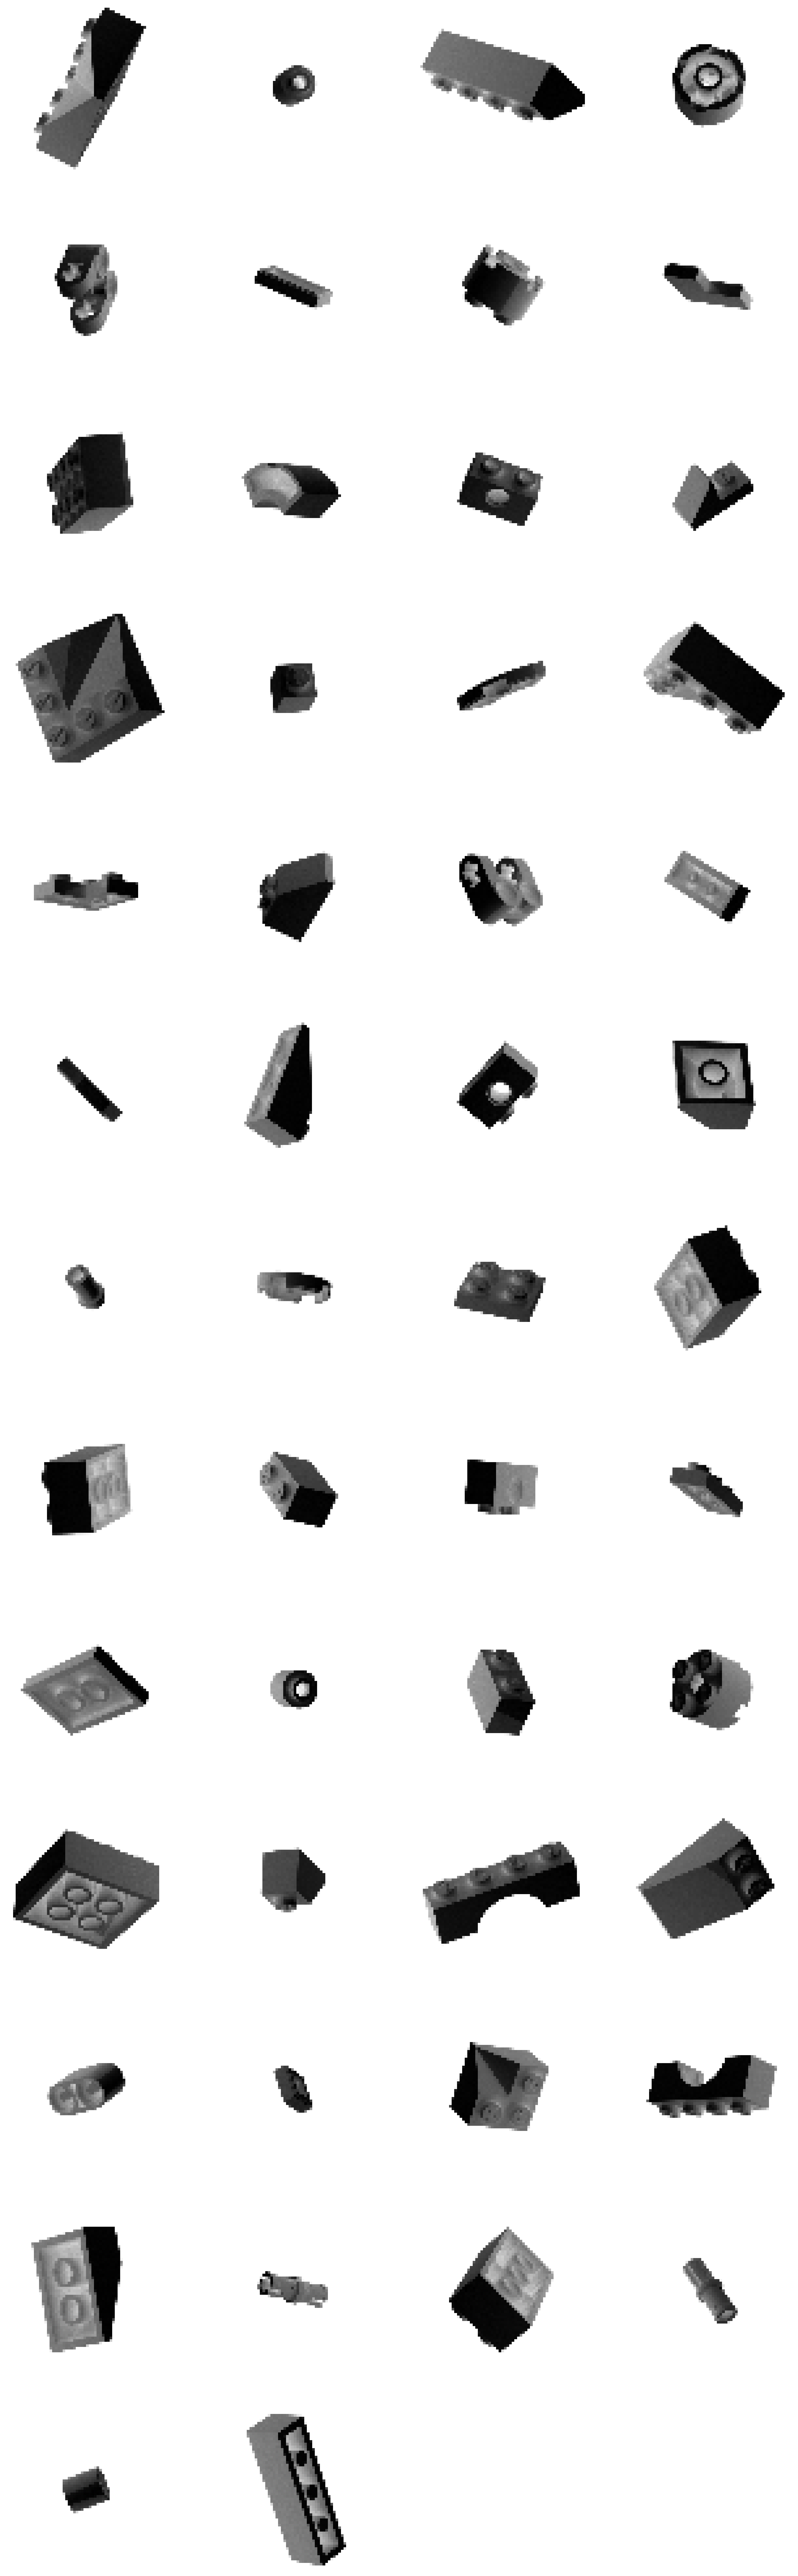

In [17]:
data_gen = iter(train_data)
max_samples = 50
sampled = 0
samples = None

while sampled < max_samples:
    cur_data = next(data_gen)
    for cur_img in cur_data[:]:
        if np.random.random() > 0.8:
            sampled += 1
            if samples is not None:
                samples = np.concatenate((samples, np.reshape(cur_img, (1,)+cur_img.shape)), axis=0)
            else:
                samples = np.reshape(cur_img, (1,)+cur_img.shape)

            if sampled >= max_samples:
                break

print(samples.shape)
imshow(samples, cols=4, color_space="gray", invert=True)


### Build Discriminator

In [18]:
discriminator_input = layers.Input(shape=(64, 64, 1))

x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.Activation(activation="sigmoid")(x)

discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)


In [19]:
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 1, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

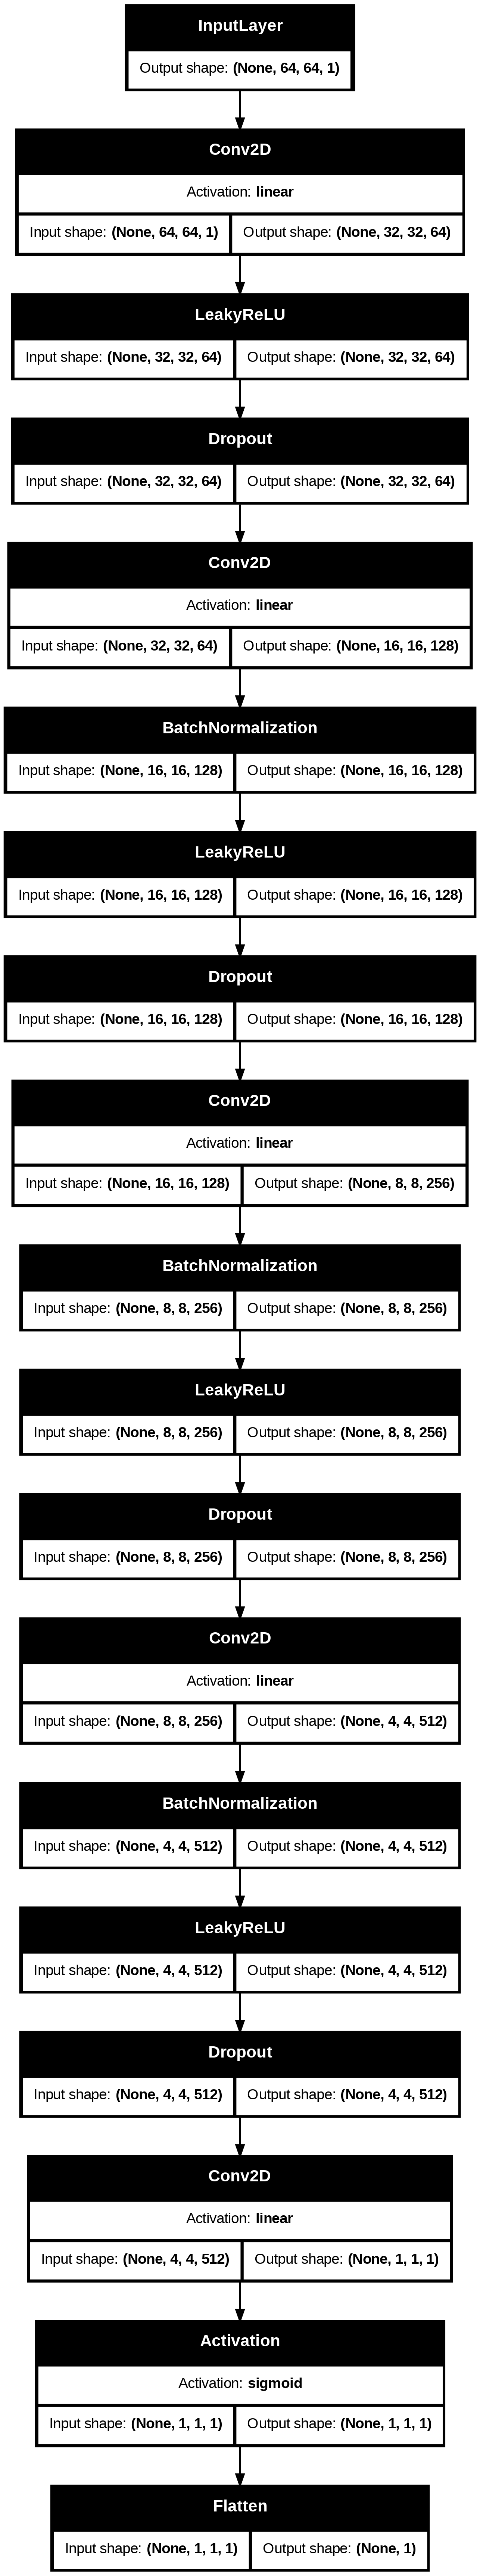

In [20]:
tf.keras.utils.plot_model(discriminator,
                          show_dtype=False,
                          show_layer_activations=True,
                          show_layer_names=False,
                          show_shapes=True
                          )

### Build the Generator

In [21]:
generator_input = layers.Input(shape=(LATENT_SPACE_DIMS, ))

x = layers.Reshape((1,1,LATENT_SPACE_DIMS))(generator_input)

x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

# x = layers.UpSampling2D(size=2)(x)
# x = layers.Conv2D(256, kernel_size=4, strides=1, padding="same")(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
generator_output = layers.Activation(activation="tanh")(x)

generator = models.Model(generator_input, generator_output)

In [22]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

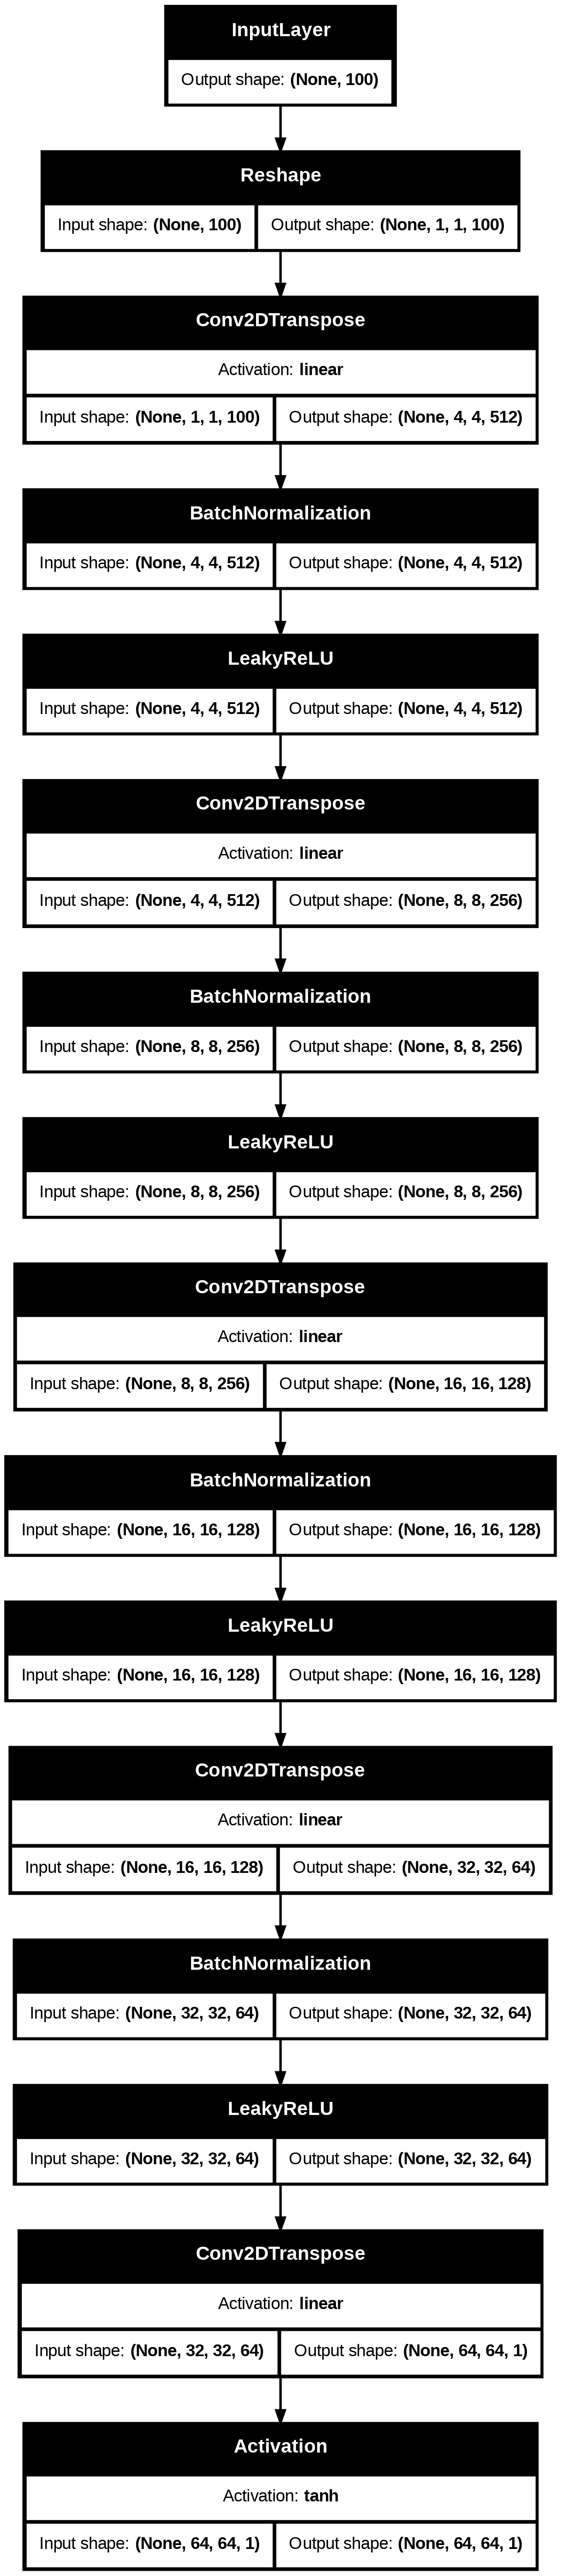

In [23]:
tf.keras.utils.plot_model(generator,
                          show_dtype=False,
                          show_layer_activations=True,
                          show_layer_names=False,
                          show_shapes=True
                          )

### Build/Implement DCGAN

In [24]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()

        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, optimizer_discriminator, optimizer_generator):
        super(DCGAN, self).compile()

        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_generator = optimizer_generator
        self.loss_metric_discriminator = tf.keras.metrics.Mean(name="discriminator_loss")
        self.loss_metric_generator = tf.keras.metrics.Mean(name="generator_loss")

    @property
    def metrics(self):
        return [self.loss_metric_discriminator, self.loss_metric_generator]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # calc loss and calc gradient, for that tf needs to know the loss
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            # make predictions
            generated_images = self.generator(random_latent_vector, training=True)

            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            # make labels
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(tf.shape(real_labels))    # label smoothing trick

            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1*tf.random.uniform(tf.shape(fake_predictions))

            # compute loss
            real_loss_discriminator = self.loss_fn(real_noisy_labels, real_predictions)
            fake_loss_discriminator = self.loss_fn(fake_noisy_labels, fake_predictions)
            loss_discriminator = (real_loss_discriminator + fake_loss_discriminator) / 2.0    # mean loss of both

            loss_generator = self.loss_fn(real_labels, fake_predictions)    # if the fakes got found as real images, the loss will be smaller, if the fakes got found as fakes the differences to the 1 labels is higher and so the loss is greater

        # gradients
        gradients_of_discriminator = dis_tape.gradient(loss_discriminator, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(loss_generator, self.generator.trainable_variables)

        # optimize weights with gradients
        self.optimizer_discriminator.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.optimizer_generator.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        # update loss metrics
        self.loss_metric_discriminator.update_state(loss_discriminator)
        self.loss_metric_generator.update_state(loss_generator)

        return {cur_metric.name:cur_metric.result() for cur_metric in self.metrics}


Add some Callbacks

In [25]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(tf.keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        imshow(
            generated_images,
            cols=self.num_img//2,
            save_to=f"./output/generated_img_{epoch:03}.png",
            color_space="gray",
            invert=True,
            title=f"Generations on Epoch: {epoch:03d}"
        )

Epoch 1/300
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - discriminator_loss: -0.8004 - generator_loss: 16.1181

Got images with shape: (10, 64, 64, 1)
Transformed shape to: (10, 64, 64, 1)
Invert images...
Using 'seaborn-v0_8'' plotting style.
Making you a beautiful plot...


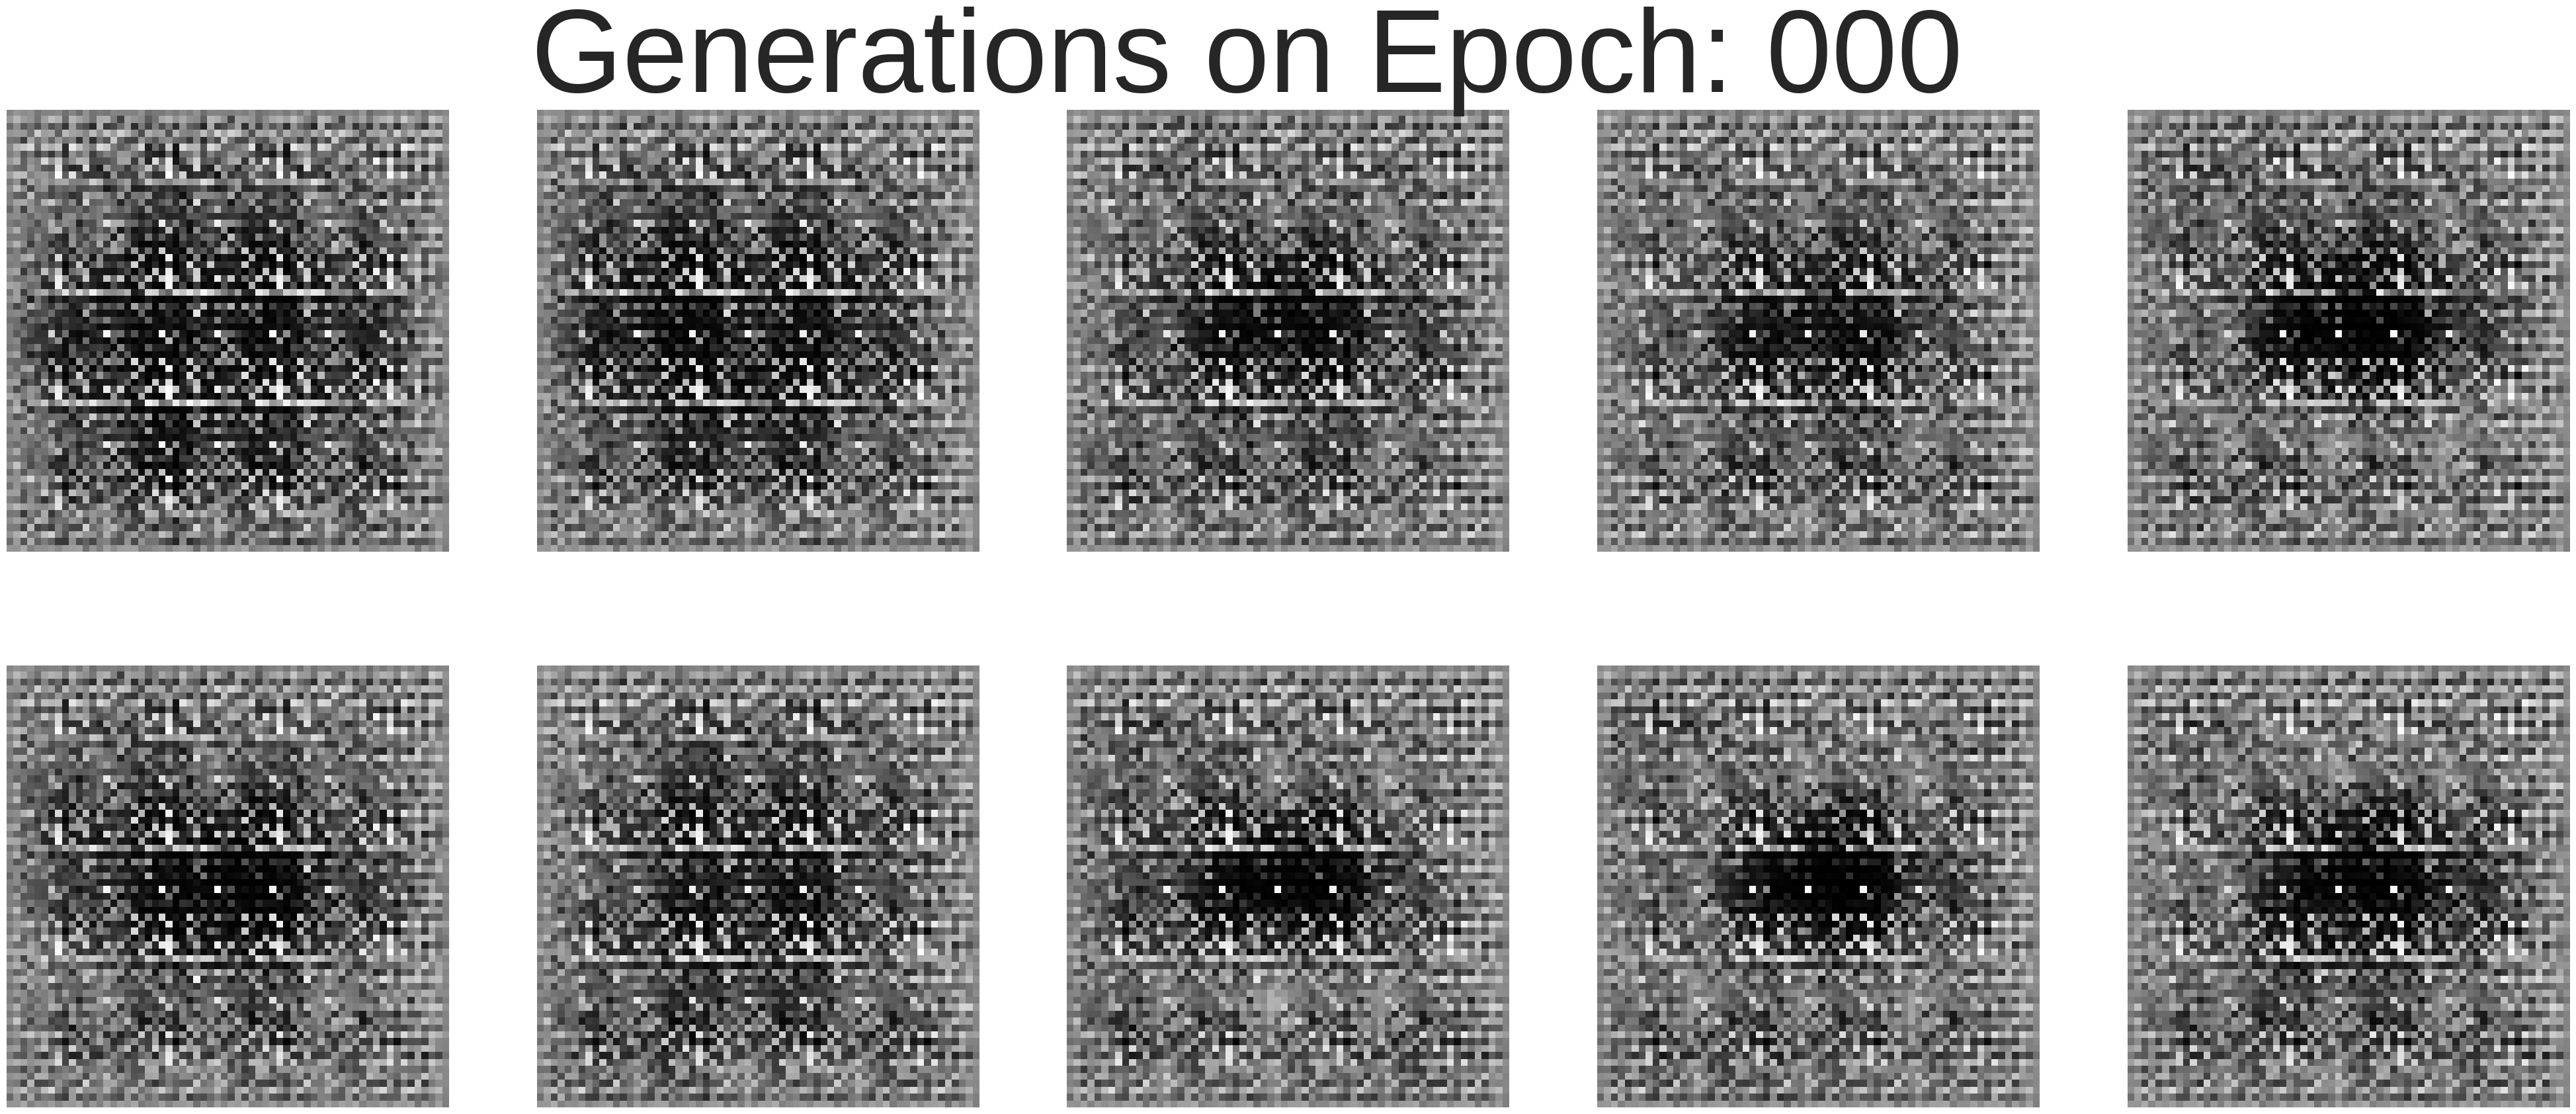

157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 438ms/step - discriminator_loss: -0.8004 - generator_loss: 16.1181
Epoch 2/300
101/157 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - discriminator_loss: -0.8009 - generator_loss: 16.1181

KeyboardInterrupt: 

In [28]:
dcgan = DCGAN(discriminator=discriminator,
              generator=generator,
              latent_dim=LATENT_SPACE_DIMS)

dcgan.compile(
    optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_DIS, beta_1=0.5, beta_2=0.999),
    optimizer_generator=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_GEN, beta_1=0.5, beta_2=0.999)
)

dcgan.fit(
    train_data,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=LATENT_SPACE_DIMS),
    ]
)

### Evaluation

Watch the train images, does it improve from each epoch?

**Originality**

One key factor of a "good"/"successfull" generative model is to create different new images and not too similiar to the train data.

To test this we can use a image similarity metric like a simple L1 distance, where we compute the pixels and build the mean of these differences.

- Best-Score: 255.0
- Worst-Score: 0.0    (no difference)

> Make sure that the value areas are the same (scaling is same) + the values are same inverted => you can analyze it visualy to check if the similarity is right!

In [ ]:
def image_similarity(n_test_runs, model, train_data, random_dropout=0.8):
    total_originality = []

    # run n experiments/generations
    for _ in range(n_test_runs):
        # generate an image
        generation = model.generator(
                            tf.random.normal(
                                    shape=(1, model.latent_dim)
                            )
                        )
        
        # postprocessing: reverse normalization
        generation = generation*(255//2) + (255//2)
        
        # fix the shape if needed
        if len(generation.shape) == 4:
            generation = np.reshape(generation, generation.shape[1:])

        # compute a originality, is the image new in comparison ot the whole train dataset?
        originality = []
        for cur_images in train_data:
            cur_images = cur_images.numpy()

            for cur_image in cur_images:
                if np.random.random() > random_dropout:
                    originality += [np.mean(np.abs(generation - cur_image))]

        total_originality = [np.mean(np.array(originality))]

    total_originality_arr = np.array(total_originality)
    total_originality_mean = np.mean(total_originality_arr)
    total_originality_var = np.var(total_originality_arr)

    print(f"\n{'-'*32}\nResult (smaller = better:)")
    print(f"Mean Originality: {total_originality_mean}")
    print(f"Variance Originality: {total_originality_var}")

    return total_originality_mean, total_originality_var



total_originality_mean, total_originality_var = image_similarity(
                                                    n_test_runs=50,
                                                    model=dcgan,
                                                    train_data=train_data,
                                                    random_dropout=0.9
                                                )

check similarity

In [ ]:
from IPython.display import clear_output

def manually_check_similarity(model, train_data):
    batches = len(train_data)
    train_data_gen = iter(train_data)

    # generate an image
    generation = model.generator(
                        tf.random.normal(
                                shape=(1, model.latent_dim)
                        )
                    )

    # postprocessing: reverse normalization
    generation = generation*(255//2) + (255//2)

    # fix the shape if needed
    if len(generation.shape) == 4:
        generation = np.reshape(generation, generation.shape[1:])

    # grap 5 samples
    # random_batch_shuffle = np.random.randint(1, batches*next(iter(train_data)).numpy().shape[0])
    random_batch_shuffle = np.random.randint(1, batches)

    for _ in range(random_batch_shuffle):
        try:
            cur_batch = next(train_data_gen)
        except Exception:    # OutOfRangeError
            train_data_gen = iter(train_data)
            cur_batch = next(train_data_gen)

    cur_batch = cur_batch.numpy()
    indices = np.random.choice(cur_batch.shape[0], size=5, replace=False)
    cur_batch = cur_batch[indices]
    title = []

    for cur_image in cur_batch:
        originality = np.mean(np.abs(generation - cur_image))
        title += [f"real, sim: {originality:.2f}"]    # :e -> scientific notation

    generation = np.reshape(generation, (1,)+ generation.shape)
    imshow(np.concatenate((generation, generation, generation, generation, generation, cur_batch), axis=0),
                        cols=5,
                        title=["generated images"]*5+title,
                        invert=True
            )



print("Compare one generated image to diferent images, are the similarity values correct?\n    (Run this cell again to get other images)\n")
manually_check_similarity(model=dcgan, train_data=train_data)


Are there missing postprocessings?
- Scaling right?
- Normalization reversed of the generated images?

---